In [1]:
#Imports
import pandas as pd
import xlrd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.over_sampling import SMOTENC
import warnings
warnings.filterwarnings("ignore")

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
df = pd.read_excel(url, header=1, index_col=0, engine='xlrd')
df.rename(columns={'default payment next month': 'default'}, inplace=True)

df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int64
 1   SEX        30000 non-null  int64
 2   EDUCATION  30000 non-null  int64
 3   MARRIAGE   30000 non-null  int64
 4   AGE        30000 non-null  int64
 5   PAY_0      30000 non-null  int64
 6   PAY_2      30000 non-null  int64
 7   PAY_3      30000 non-null  int64
 8   PAY_4      30000 non-null  int64
 9   PAY_5      30000 non-null  int64
 10  PAY_6      30000 non-null  int64
 11  BILL_AMT1  30000 non-null  int64
 12  BILL_AMT2  30000 non-null  int64
 13  BILL_AMT3  30000 non-null  int64
 14  BILL_AMT4  30000 non-null  int64
 15  BILL_AMT5  30000 non-null  int64
 16  BILL_AMT6  30000 non-null  int64
 17  PAY_AMT1   30000 non-null  int64
 18  PAY_AMT2   30000 non-null  int64
 19  PAY_AMT3   30000 non-null  int64
 20  PAY_AMT4   30000 non-null  int64
 21  PAY_AMT5   30000 

In [4]:
# Define target and features
X = df.drop(columns='default')
y = df['default']

acc_baseline= y.value_counts(normalize=True).max()
print(f"The baseline accuracy is: {acc_baseline}")

The baseline accuracy is: 0.7788


In [5]:
#Preprocessing
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
numerical_features = [col for col in X.columns if col not in categorical_features]

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Create a preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (24000, 23)
Shape of X_test: (6000, 23)
Shape of y_train: (24000,)
Shape of y_test: (6000,)


#Random Forest

In [7]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

In [8]:
log_reg= RandomForestClassifier(random_state=42)
log_reg.fit(X_train_processed, y_train)
y_pred_normal = log_reg.predict(X_test_processed)

In [9]:
# Calculate metrics on the test set
accuracy = accuracy_score(y_test, y_pred_normal)
precision = precision_score(y_test, y_pred_normal)
f1 = f1_score(y_test, y_pred_normal)
recall = recall_score(y_test, y_pred_normal)
auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_processed)[:, 1])

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.8172
Precision: 0.6456
F1 Score: 0.4662
Recall: 0.3648
AUC: 0.7591


In [10]:
print("Random Forest without Imbalance correction")
print(classification_report(y_test, y_pred_normal, zero_division=0))
print(confusion_matrix(y_test, y_pred_normal))

Random Forest without Imbalance correction
              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4687
           1       0.65      0.36      0.47      1313

    accuracy                           0.82      6000
   macro avg       0.74      0.65      0.68      6000
weighted avg       0.80      0.82      0.80      6000

[[4424  263]
 [ 834  479]]


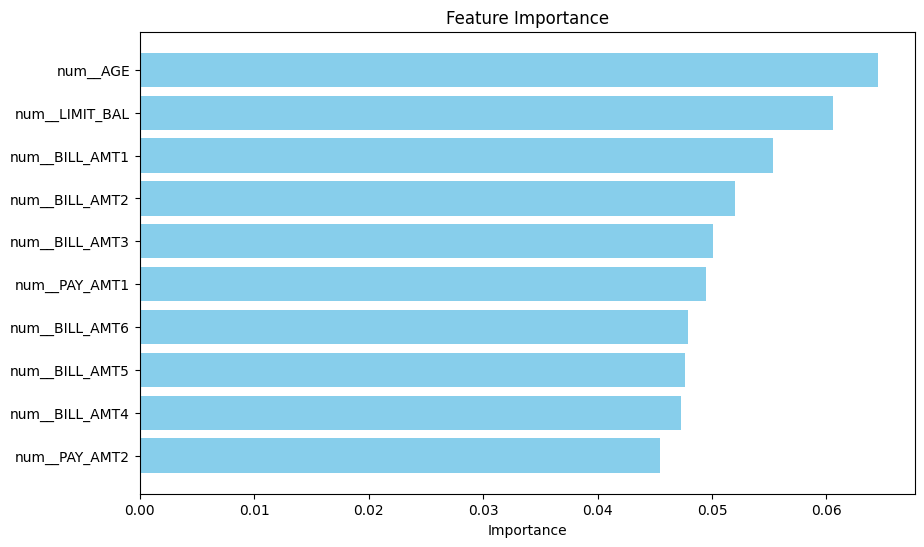

In [11]:
feature_importances = log_reg.feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for better plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.head(10).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [12]:
under = RandomUnderSampler(random_state=42)
X_train_under,y_train_under= under.fit_resample(X_train_processed,y_train)

In [13]:
log_reg_under= RandomForestClassifier(random_state=42)
log_reg_under.fit(X_train_under, y_train_under)
y_pred_under = log_reg_under.predict(X_test_processed)

In [14]:
# Calculate metrics on the test set
accuracy = accuracy_score(y_test, y_pred_under)
precision = precision_score(y_test, y_pred_under)
f1 = f1_score(y_test, y_pred_under)
recall = recall_score(y_test, y_pred_under)
auc = roc_auc_score(y_test, log_reg_under.predict_proba(X_test_processed)[:, 1])

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.7328
Precision: 0.4239
F1 Score: 0.5020
Recall: 0.6154
AUC: 0.7588


In [15]:
print("Random Forest with UnderSampling")
print(classification_report(y_test, y_pred_under, zero_division=0))
print(confusion_matrix(y_test, y_pred_under))

Random Forest with UnderSampling
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      4687
           1       0.42      0.62      0.50      1313

    accuracy                           0.73      6000
   macro avg       0.65      0.69      0.66      6000
weighted avg       0.78      0.73      0.75      6000

[[3589 1098]
 [ 505  808]]


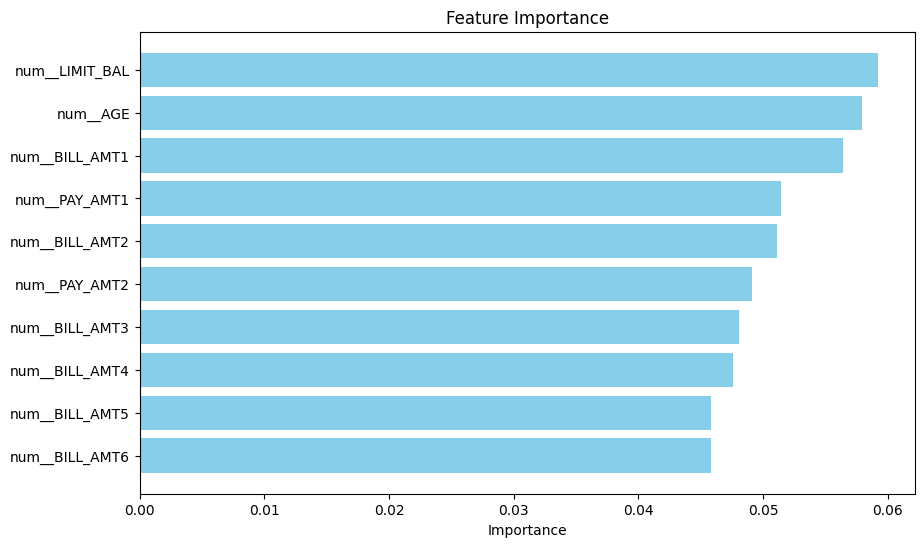

In [16]:
feature_importances = log_reg_under.feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for better plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.head(10).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [17]:
over = RandomOverSampler(random_state=42)
X_train_over,y_train_over= over.fit_resample(X_train_processed,y_train)

In [18]:
log_reg_over= RandomForestClassifier(random_state=42)
log_reg_over.fit(X_train_over, y_train_over)
y_pred_over = log_reg_over.predict(X_test_processed)

In [19]:
# Calculate metrics on the test set
accuracy = accuracy_score(y_test, y_pred_over)
precision = precision_score(y_test, y_pred_over)
f1 = f1_score(y_test, y_pred_over)
recall = recall_score(y_test, y_pred_over)
auc = roc_auc_score(y_test, log_reg_over.predict_proba(X_test_processed)[:, 1])

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

Accuracy: 0.8108
Precision: 0.5925
F1 Score: 0.5011
Recall: 0.4341
AUC: 0.7575


In [20]:
print("Random Forest with OverSampling")
print(classification_report(y_test, y_pred_over, zero_division=0))
print(confusion_matrix(y_test, y_pred_over))

Random Forest with OverSampling
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      4687
           1       0.59      0.43      0.50      1313

    accuracy                           0.81      6000
   macro avg       0.72      0.68      0.69      6000
weighted avg       0.80      0.81      0.80      6000

[[4295  392]
 [ 743  570]]


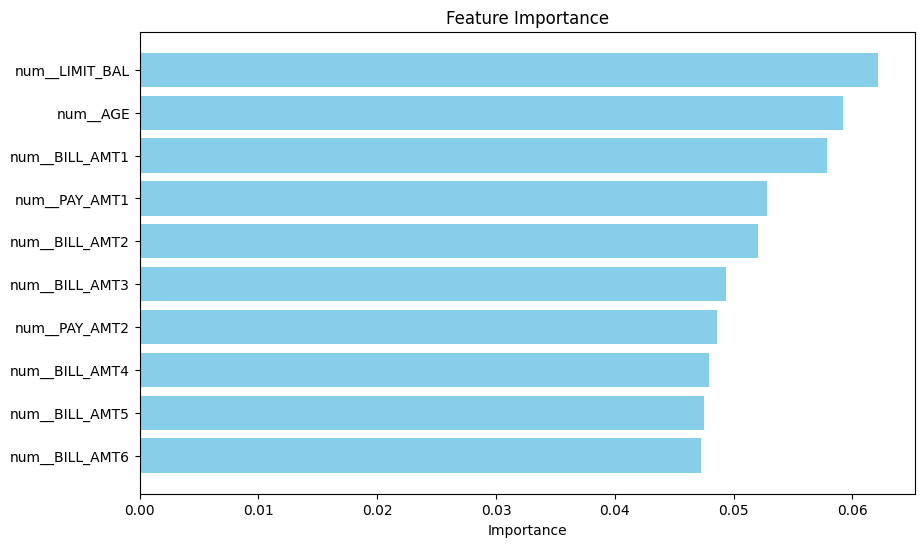

In [21]:
feature_importances = log_reg_over.feature_importances_
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for better plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.head(10).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [22]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train_processed, y_train)

In [23]:
log_reg_smote= LogisticRegression(random_state=42)
log_reg_smote.fit(X_smote, y_smote)
y_pred_smote = log_reg_smote.predict(X_test_processed)

NameError: name 'LogisticRegression' is not defined

In [ ]:
# Calculate metrics on the test set
accuracy = accuracy_score(y_test, y_pred_smote)
precision = precision_score(y_test, y_pred_smote)
f1 = f1_score(y_test, y_pred_smote)
recall = recall_score(y_test, y_pred_smote)
auc = roc_auc_score(y_test, log_reg_smote.predict_proba(X_test_processed)[:, 1])

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"AUC: {auc:.4f}")

In [ ]:
print("Random Forest with SMOTE")
print(classification_report(y_test, y_pred_smote, zero_division=0))
print(confusion_matrix(y_test, y_pred_smote))

In [ ]:
feature_importances = abs(log_reg_smote.coef_[0])
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for better plotting
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.head(10).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()